#### Exercise 1 - Bank dataset

#### Bank marketing dataset
https://www.openml.org/search?type=data&sort=runs&id=1461&status=active

#### Bank Marketing Context
The data is related with direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

#### Columns description
bank client data:
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur", "student","blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**output variable (desired target):**

17 - y - has the client subscribed a term deposit? (binary: "yes","no")



#### Possible research questions:
- Predict whether a customer will subscribe to a term deposit or not
- Which variables are the most significant?
- Which customer segment should be targeted the most?




##### Important libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay,make_scorer
from sklearn.model_selection import GridSearchCV


##### Loading the data

In [2]:
#directly downloading from openml
dataset = openml.datasets.get_dataset(1461)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute)

In [3]:
df_bank = pd.DataFrame(X, columns=attribute_names)
df_bank["class"] = y
df_bank.head(5)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,class
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261.0,1,-1.0,0.0,unknown,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151.0,1,-1.0,0.0,unknown,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76.0,1,-1.0,0.0,unknown,1
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92.0,1,-1.0,0.0,unknown,1
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198.0,1,-1.0,0.0,unknown,1


In [4]:
# rename columns
column_names_bank = ['age', 'job', 'marital', 'education', 'default',
                     'balance', 'housing', 'loan', 'contact', 'day',
                     'month', 'duration', 'campaign', 'pdays',
                     'previous', 'poutcome', 'class']
df_bank.columns = column_names_bank

#### Data preprocessing

In [5]:
# Number of samples and number of attributes
num_samples = df_bank.shape[0]
num_attributes = df_bank.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  45211
The number of attributes is:  16


In [6]:
# print number of unknown values:
num_unknown = 0
for n in column_names_bank:
  num_unknown_per_feature = df_bank.loc[:,n].isin(['unknown']).sum(axis=0)
  num_unknown += num_unknown_per_feature
  print(n, ':', num_unknown_per_feature)
print('total unknown:', num_unknown)

#for the moment, I decided to keep these missing values as they are

age : 0
job : 288
marital : 0
education : 1857
default : 0
balance : 0
housing : 0
loan : 0
contact : 13020
day : 0
month : 0
duration : 0
campaign : 0
pdays : 0
previous : 0
poutcome : 36959
class : 0
total unknown: 52124


In [7]:
print(df_bank.dtypes)

age             uint8
job          category
marital      category
education    category
default      category
balance       float64
housing      category
loan         category
contact      category
day             uint8
month        category
duration      float64
campaign        uint8
pdays         float64
previous      float64
poutcome     category
class        category
dtype: object


In [8]:
#print out null values

df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
class        0
dtype: int64

In [9]:
#Counting the number of samples for each class
bank = df_bank.to_numpy()
bank_num_class_1 = sum(bank[:, -1] == '1')
bank_num_class_2 = sum(bank[:, -1] == '2')

print("Number of samples that belong to class 1: ", str(bank_num_class_1))
print("Number of samples that belong to class 2: ", str(bank_num_class_2))


Number of samples that belong to class 1:  39922
Number of samples that belong to class 2:  5289


As seen above, our dataset is highly imbalanced with the majority class being class 1 (clients who have subscribed to a term deposit) and minority class class 2 (clients who have not subscribed to a term deposit). Imbalanced dataset are very common in classification tasks and this issue may affect our overall prediction accuracy.

Looking into our data columns:

`Class Column`

In [10]:
df_bank['class'] = df_bank['class'].map({'1': 1, '2': 0})

In [11]:
df_bank['class'] = df_bank['class'].astype('int64')

`Job Column`

In [12]:
df_bank.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [13]:
#investigating job vs term deposit (y)

df_bank[df_bank['class'] ==1][['job','class']].groupby(['job','class']).size()

job            class
admin.         1        4540
blue-collar    1        9024
entrepreneur   1        1364
housemaid      1        1131
management     1        8157
retired        1        1748
self-employed  1        1392
services       1        3785
student        1         669
technician     1        6757
unemployed     1        1101
unknown        1         254
dtype: int64

In [14]:
#some jobs look like can be combined together into same category
df_bank['job'] = df_bank['job'].replace(['services','housemaid'], 'pink-collar')
df_bank['job'] = df_bank['job'].replace(['admin','management'], 'blue-collar')
df_bank['job'] = df_bank['job'].replace(['student','unemployed','retired'], 'other')


In [15]:
#new value count
df_bank.job.value_counts()

blue-collar      19190
technician        7597
pink-collar       5394
admin.            5171
other             4505
self-employed     1579
entrepreneur      1487
unknown            288
Name: job, dtype: int64

`Contact`

In [16]:
#dropping this column since it does not bring much value to our analysis
df_bank.drop('contact', axis=1, inplace=True)

`Default, Housing, Loan`

In [17]:
#converting their values to integers 1 and 0
df_bank['default'] = df_bank['default'].map({'yes': 1, 'no': 0})
df_bank.default = df_bank['default'].astype('int64')

df_bank['housing'] = df_bank['housing'].map({'yes': 1, 'no': 0})
df_bank.housing = df_bank['housing'].astype('int64')

df_bank['loan'] = df_bank['loan'].map({'yes': 1, 'no': 0})
df_bank.loan = df_bank['loan'].astype('int64')

`Month & Day`

In [18]:
#dropping these columns since they do not bring much value to our analysis
df_bank.drop('month', axis=1, inplace=True)
df_bank.drop('day', axis=1, inplace=True)

`Pdays`

In [19]:
#this column gives information about the last time the clients were contacted
#value of -1 indicates that the client was not contacted at all
print('Number of clients not contacted:',df_bank[df_bank['pdays']==-1].shape[0])
print('Number of clients  contacted:',df_bank[df_bank['pdays']!=-1].shape[0])

Number of clients not contacted: 36954
Number of clients  contacted: 8257


In [20]:
#we are going to replace of the value of -1 with a bigger value(indicates that this is so far in the past and it should not have an effect anymore)

# df_bank.loc[df_bank['pdays'] == -1, 'pdays'] = 100000

`Poutcome`

In [21]:
df_bank['poutcome'].unique()

['unknown', 'failure', 'other', 'success']
Categories (4, object): ['failure' < 'other' < 'success' < 'unknown']

In [22]:
# Replacing 'other' with unknown since for both of them we do not have valuable information
df_bank['poutcome'] = df_bank['poutcome'].replace('other', 'unknown')


#### Exploratory data analysis

In [23]:
numeric_columns = ['age','balance','duration','pdays','previous','campaign']
#list of categorical columns
categorical_columns = [i for i in df_bank.columns if i not in numeric_columns and i !='class']

In [24]:
df_bank.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
default,45211.0,0.018027,0.133049,0.0,0.0,0.0,0.0,1.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211.0,0.555838,0.496878,0.0,0.0,1.0,1.0,1.0
loan,45211.0,0.160226,0.366820,0.0,0.0,0.0,0.0,1.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0
class,45211.0,0.883015,0.321406,0.0,1.0,1.0,1.0,1.0


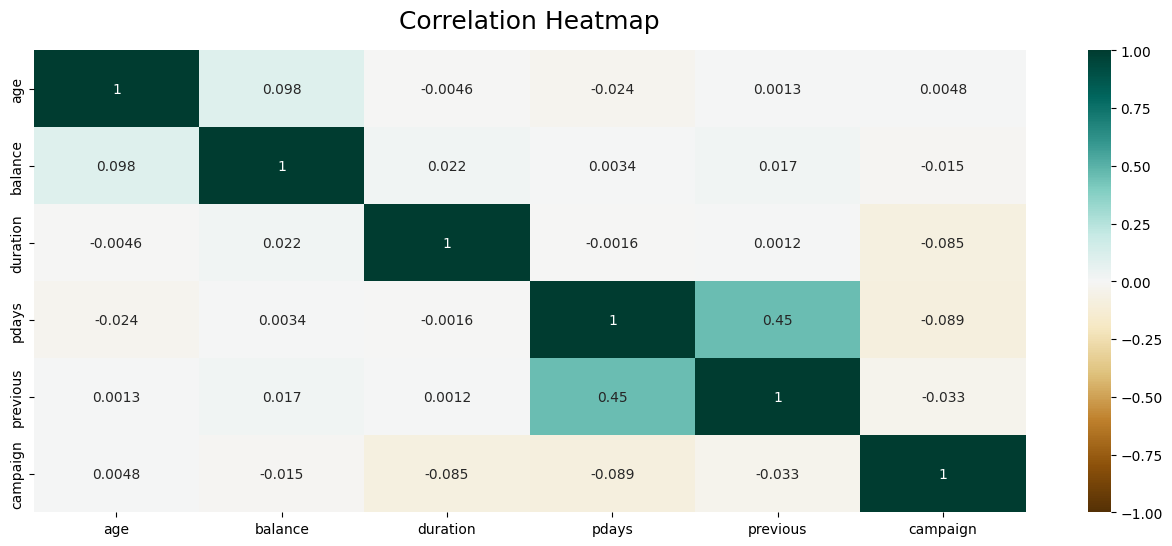

In [25]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_bank[numeric_columns].corr(),vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
# plt.savefig('bank_heatmap.jpg',)
plt.show()

Observations:
- There is some correlation between our variable but none of those can be considered very high

In [26]:
def creating_box_hist(column, df):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_dis) = plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.20, .80)},figsize=(8, 5))  
    mean=df[column].mean()
    median=df[column].median()
    mode=df[column].mode().tolist()[0]

    f.suptitle("Data distribution of  "+ column  , fontsize=10, fontweight='bold')
    # assigning a graph to each ax

    sns.boxplot(df[column], ax=ax_box,orient = 'h',showmeans = True)

    sns.despine(top=True,right=True,left=True)
    sns.histplot(df[column],kde=False,ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})


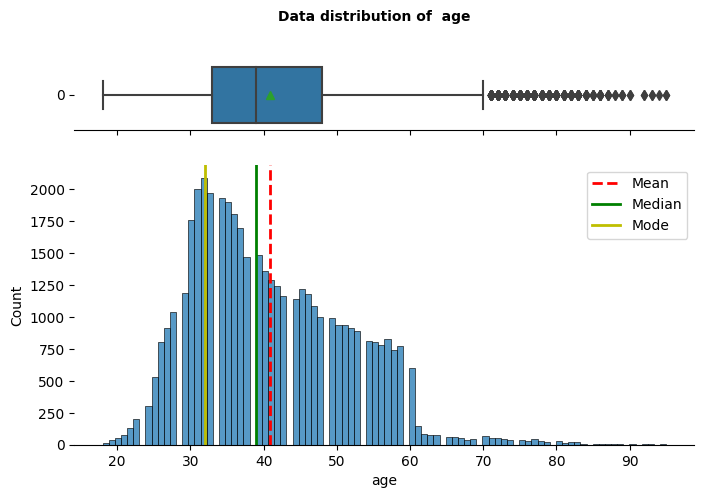

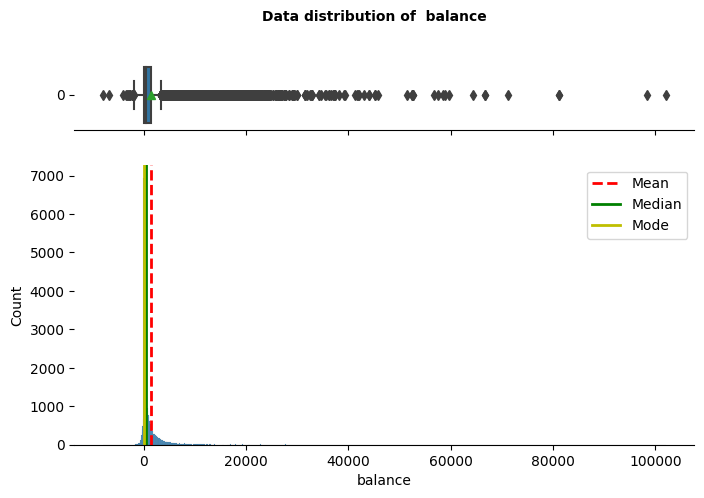

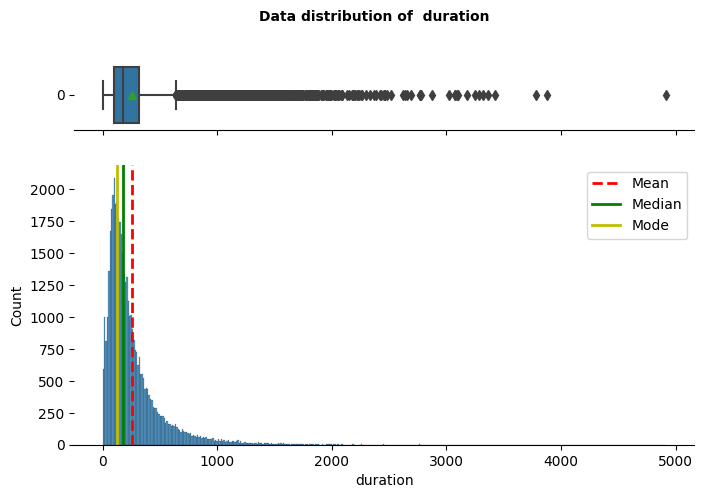

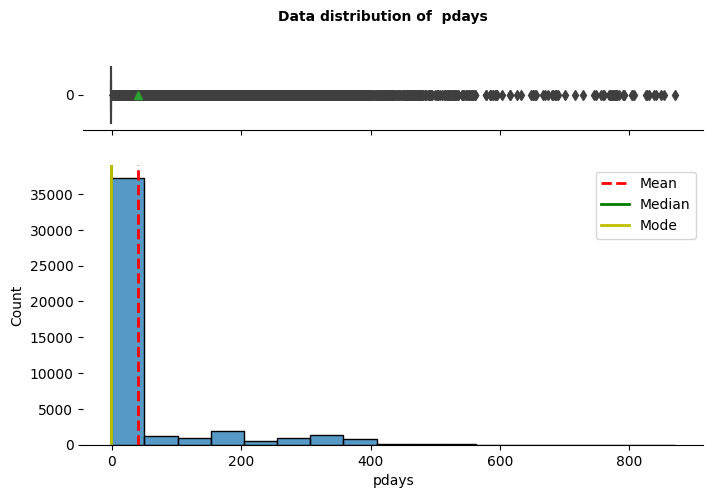

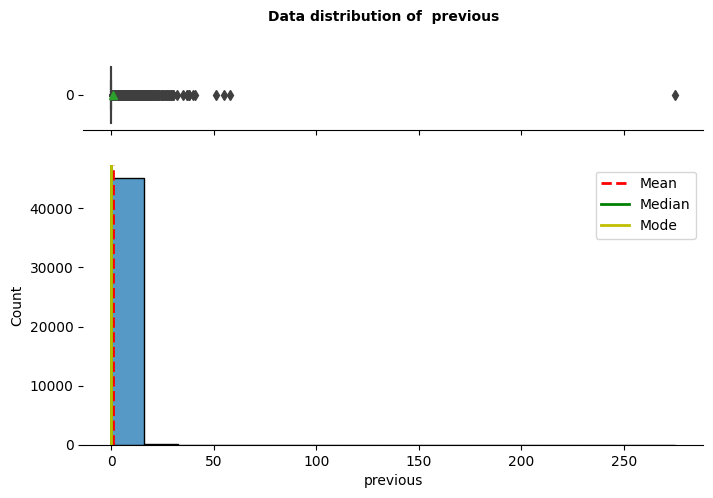

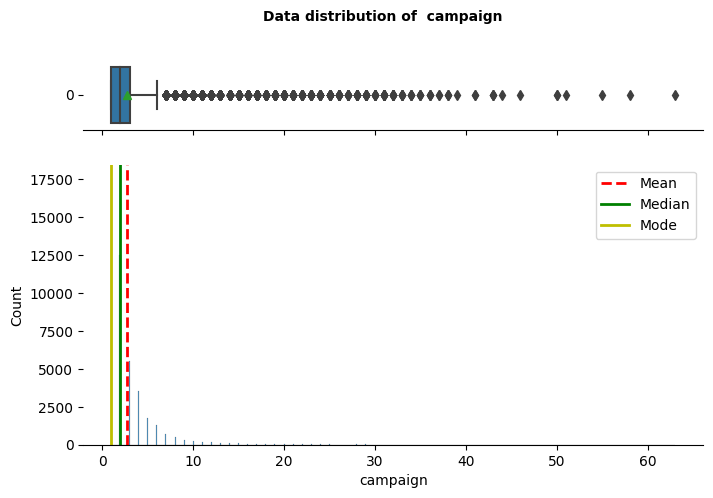

In [27]:
# Plots of numeric columns
for i in numeric_columns:
    creating_box_hist(i,df_bank)

##### Observations:
- As seen above, the majority of our data is right-skewed, eg. `Age`, `Balance` and `Duration`, `Campaign` and they have a lot of outliers.
- `Pdays` is mostly -1 which refers to the clients that have not been contacted at all and there are a lot of outliers in the data
- `Previous` is mostly 0 and there are again a lot of outliers in the data.


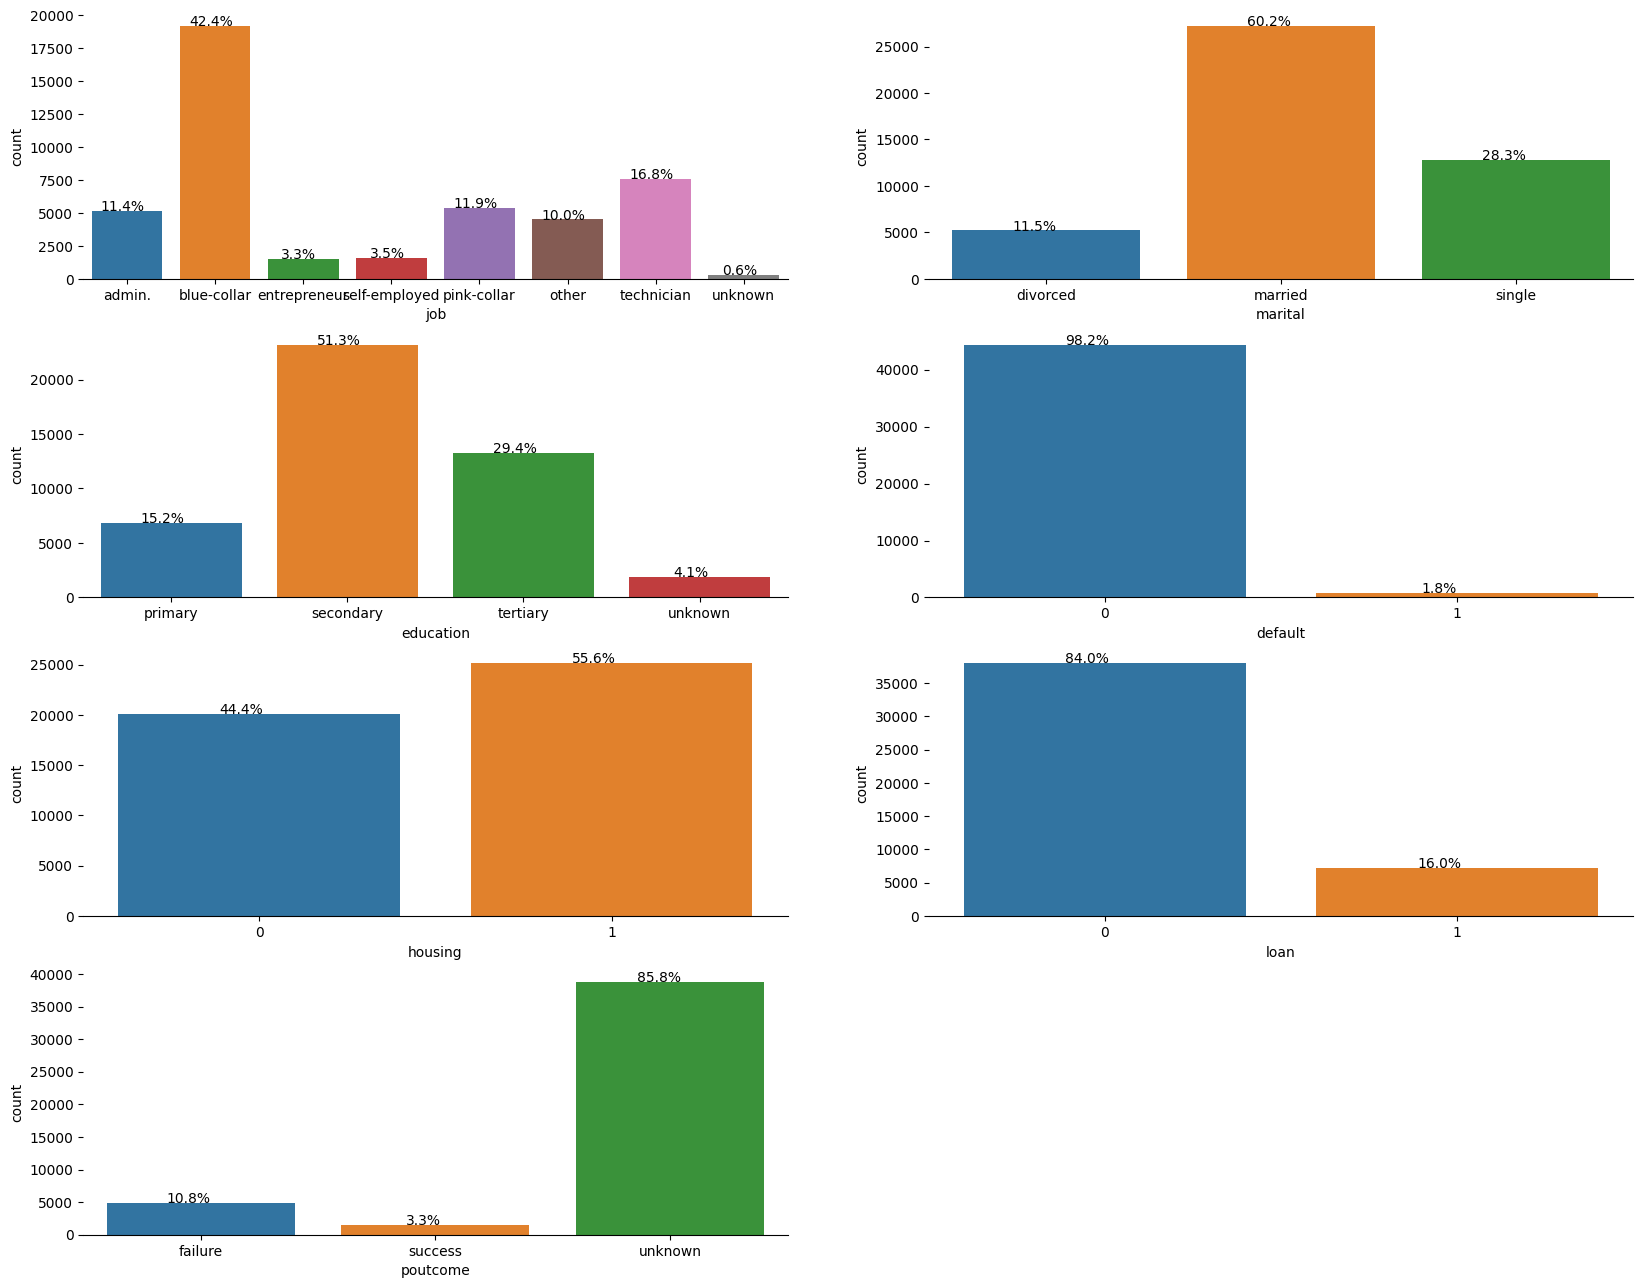

In [28]:
# Plotting the categorical variables

plt.figure(figsize=(20,20))
for i, variable in enumerate(categorical_columns):
                     plt.subplot(5,2,i+1)
                     order = df_bank[variable].value_counts(ascending=False).index 
                     ax=sns.countplot(x=df_bank[variable], data=df_bank )
                     sns.despine(top=True,right=True,left=True)
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_bank[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')


Observations:

- `42.4%` of the clients are blue-collar employees
- `60.2%` of the clients are married
- `51.3%` of the clients have finished secondary education
- `98.2%` of the clients do not have a credit in default
- `55.6%` of the clients have housing loan
- `84%` of the clients have a personal loan 
- For `85.8%` of the clients the outcome of the previous marketing campaign is unknown

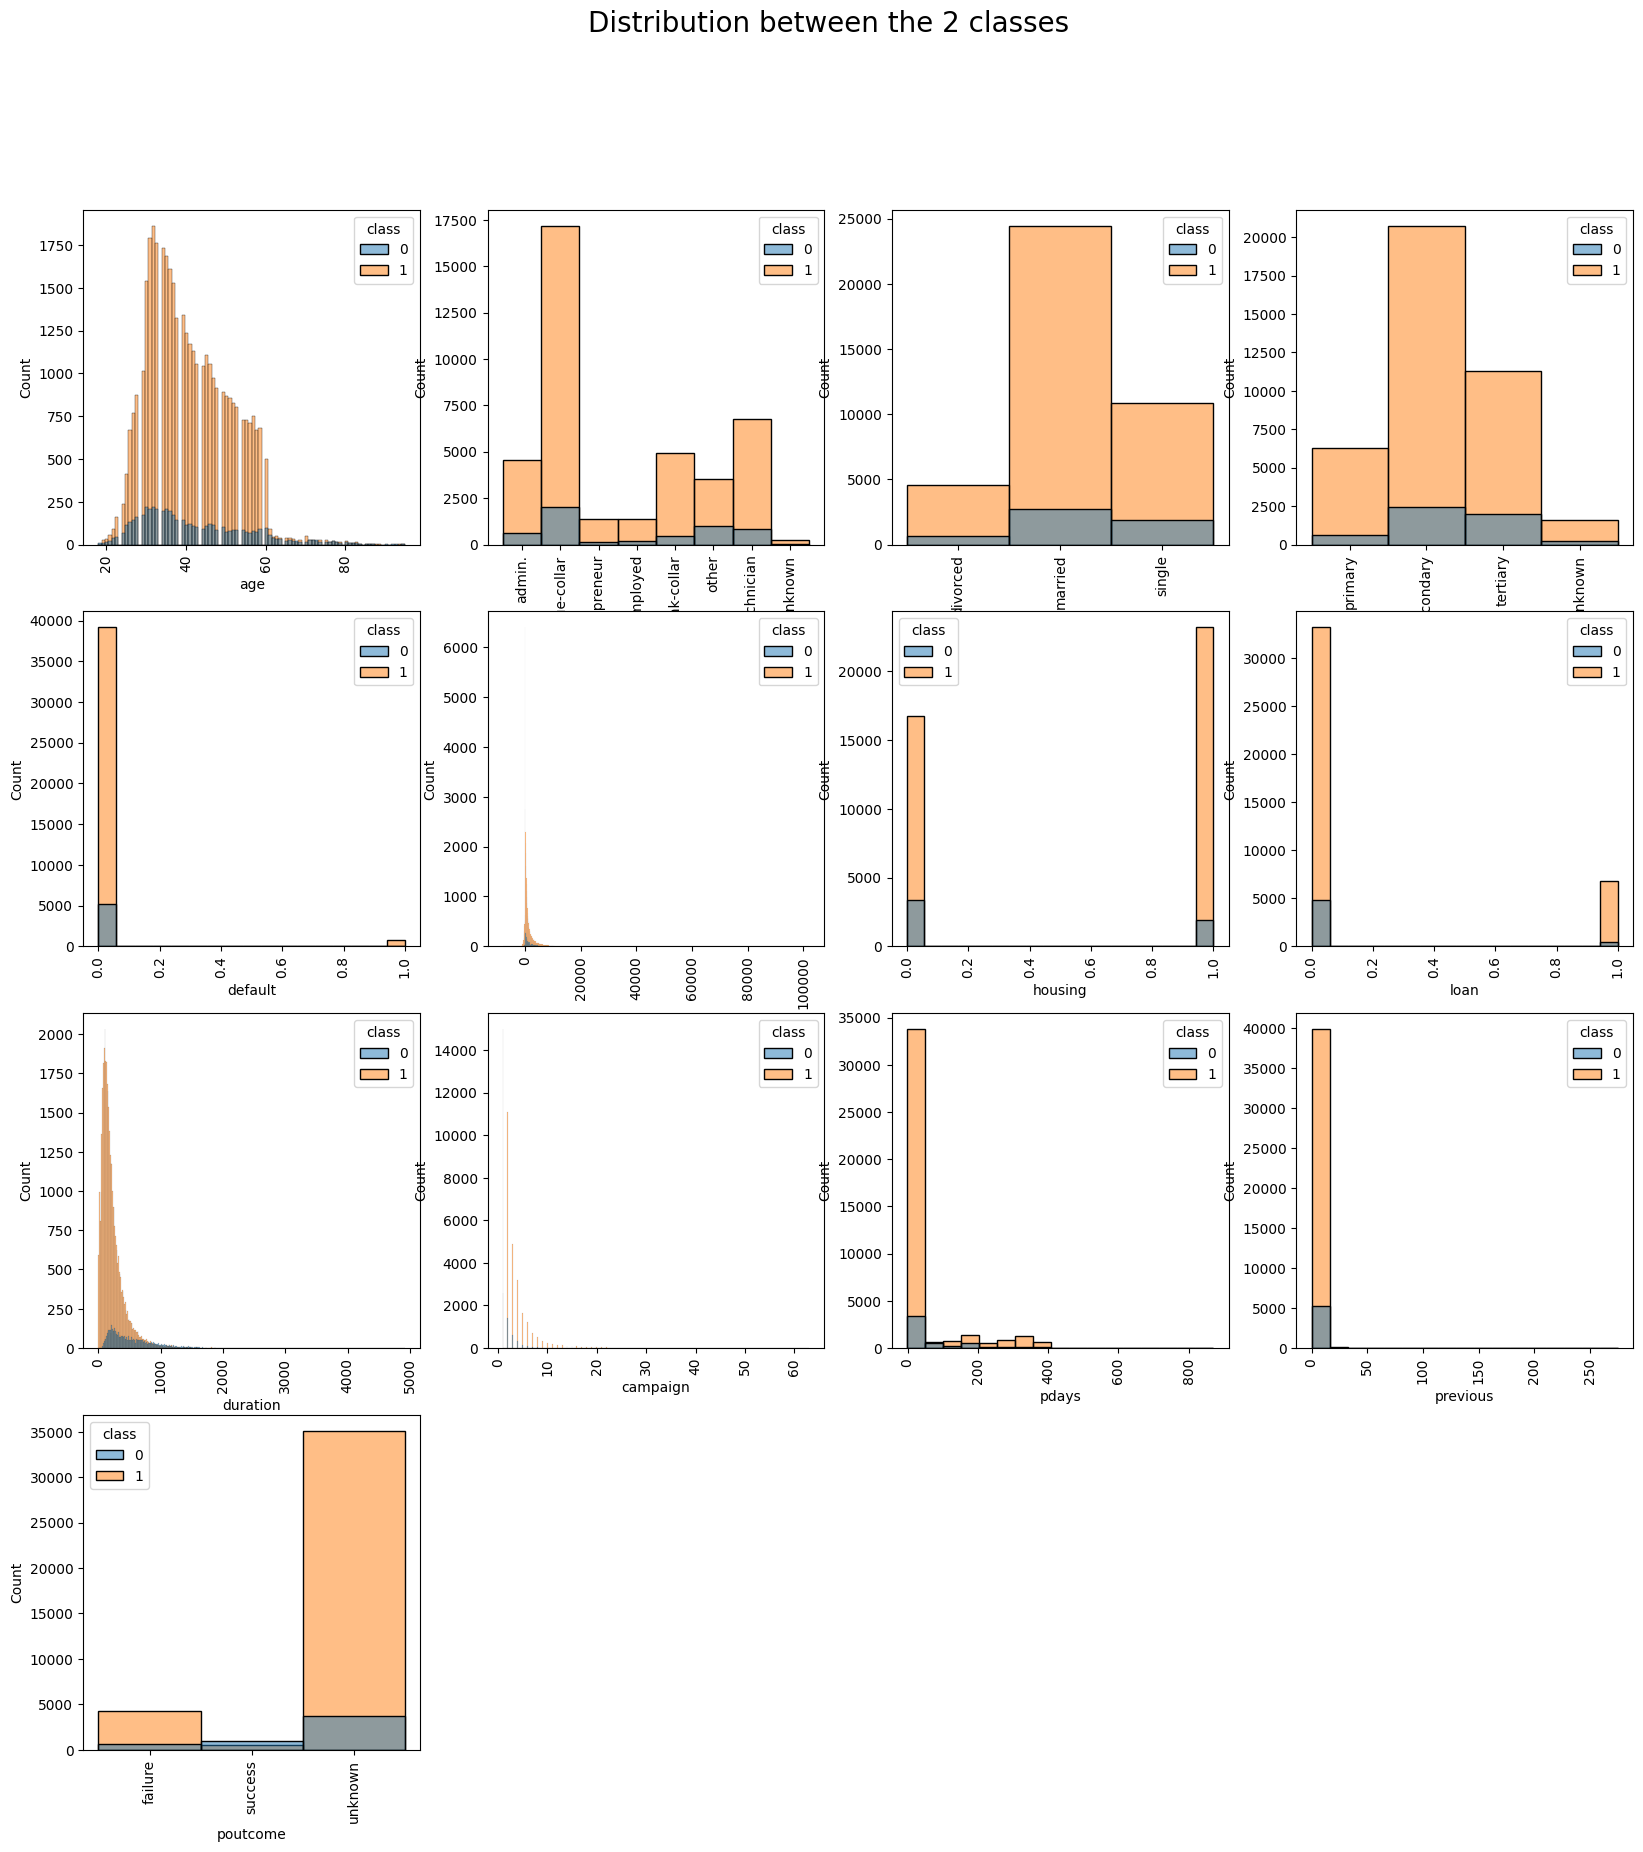

In [29]:

plt.figure(figsize=(20,20))
for i,column in enumerate([i for i in df_bank.columns.tolist() if i!='class']):
    plt.subplot(4, 4, i+1)
    sns.histplot(x=df_bank[column],hue =df_bank['class'])
    plt.xlabel(column)
    plt.xticks(rotation=90)
plt.suptitle("Distribution between the 2 classes ", fontsize=20)
plt.show()

##### Observations:
- It looks like people between age of 30 to 40 are more likely to agree to a subscription loan.
- Number of clients employeed as a blue-collar employee that have agreed to a subscription is the highest.
- Number of clients that have finished secondary education that have agreed to a subscription is the highest.
- The majority of clients who have a credit in default or have a personal loan do not agree to a subscription
- Number of people who have not agreed to a subscription is high whether they have a housing loan or not
- Number of people about who the previous campaign result is unknow and has subscripted is high as oposed to those that had an outcome like failure.

#### Converting categorical variables to dummy variables

In [30]:
df_bank_dummies = pd.get_dummies(df_bank, columns=['job','marital','education','poutcome'],
 prefix = ['job','marital','education','poutcome'])

In [31]:
df_bank_dummies.dtypes

age                      uint8
default                  int64
balance                float64
housing                  int64
loan                     int64
duration               float64
campaign                 uint8
pdays                  float64
previous               float64
class                    int64
job_admin.               uint8
job_blue-collar          uint8
job_entrepreneur         uint8
job_self-employed        uint8
job_pink-collar          uint8
job_other                uint8
job_technician           uint8
job_unknown              uint8
marital_divorced         uint8
marital_married          uint8
marital_single           uint8
education_primary        uint8
education_secondary      uint8
education_tertiary       uint8
education_unknown        uint8
poutcome_failure         uint8
poutcome_success         uint8
poutcome_unknown         uint8
dtype: object

#### Train and Test split

In [32]:
X = df_bank_dummies.drop(['class'], axis=1)
Y = df_bank_dummies['class']

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state = 1234,stratify=Y)

#### Decision Trees

In [33]:
#Counting the number of samples for each class
bank = df_bank.to_numpy()
bank_num_class_1 = sum(bank[:, -1] == 1)
bank_num_class_2 = sum(bank[:, -1] == 0)
print("Number of samples that belong to class 1: ", str(bank_num_class_1),bank_num_class_1/len(df_bank), '%')
print("Number of samples that belong to class 0: ", str(bank_num_class_2),bank_num_class_2/len(df_bank), '%')


Number of samples that belong to class 1:  39922 0.8830151954170445 %
Number of samples that belong to class 0:  5289 0.11698480458295547 %


- As mentioned above, our dataset is highly imbalanced. 88% of the data is represented by clients who have subscribed to a term deposit and aroung 12% by clients who have not agreed to a term deposit. Since this may have a massive effect on our prediction and the decision trees will surely be biased toward the dominant class, we can make use of the `class_weight`parameter of the model. By passing such a dictionary value {1:0.35, 0:65} to the model parameter, the decision tree will surely give more weightage to class 0. For splitting the tree we opted for gini criteria.

- It is very important to identify potential customers correctly. Recall is a suitable metric in this context. The higher recall, the lower the number of False Negatives.






In [34]:
tree_model_random = tree.DecisionTreeClassifier(criterion = 'gini',class_weight={1:0.25,0:0.75}, random_state=1)
tree_model_random.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, random_state=1)

In [35]:
def evaluate(model):
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # accuracy
    print("#"*20)
    print("Accuracy on train: ", accuracy_score(y_train, y_train_predict))
    print("Accuracy on test: ", accuracy_score(y_test, y_test_predict))
    print("#"*20)
    print("Recall on train: ", recall_score(y_train, y_train_predict))
    print("Recall on test: ", recall_score(y_test, y_test_predict))

    print("#"*20)
    print("Confusion Matrix on train:")
    c1 = confusion_matrix(y_train, y_train_predict)
    cmd = ConfusionMatrixDisplay(c1, display_labels=['subscribed_no','subscribed_yes'])
    cmd.plot(cmap=plt.cm.Blues)
    print("Confusion Matrix on test:")
    c2 = confusion_matrix(y_test, y_test_predict)
    cmd = ConfusionMatrixDisplay(c2, display_labels=['subscribed_no','subscribed_yes'])
    cmd.plot(cmap=plt.cm.Blues)
    plt.show()
 

####################
Accuracy on train:  1.0
Accuracy on test:  0.853698993696782
####################
Recall on train:  1.0
Recall on test:  0.9138384470882905
####################
Confusion Matrix on train:
Confusion Matrix on test:


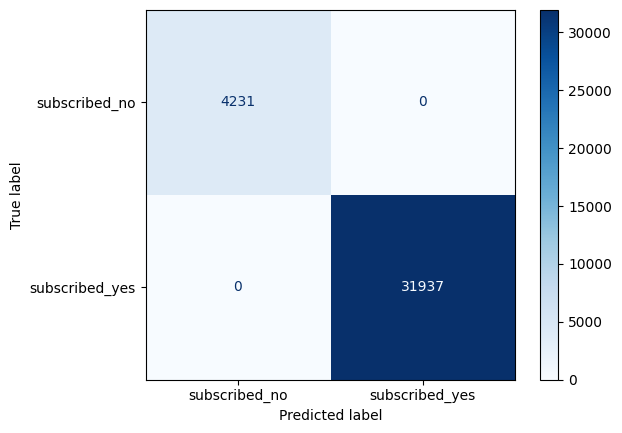

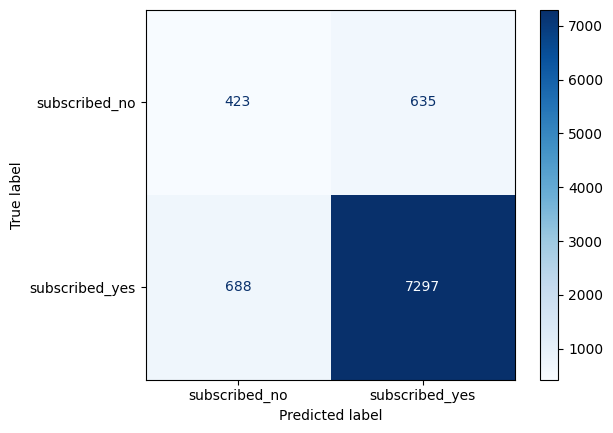

In [36]:
evaluate(tree_model_random)

- As seen above the recall and accuracy is very high on the train set, which suggests that the model is overfitted.

#### Plotting the decision tree

In [37]:
#features of the model
features = list(X_train)

Function for plotting the tree

In [38]:
def plottree(model):
    plt.figure(figsize=(20,30))
    plot = tree.plot_tree(model,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
    for o in plot:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)
    plt.show()

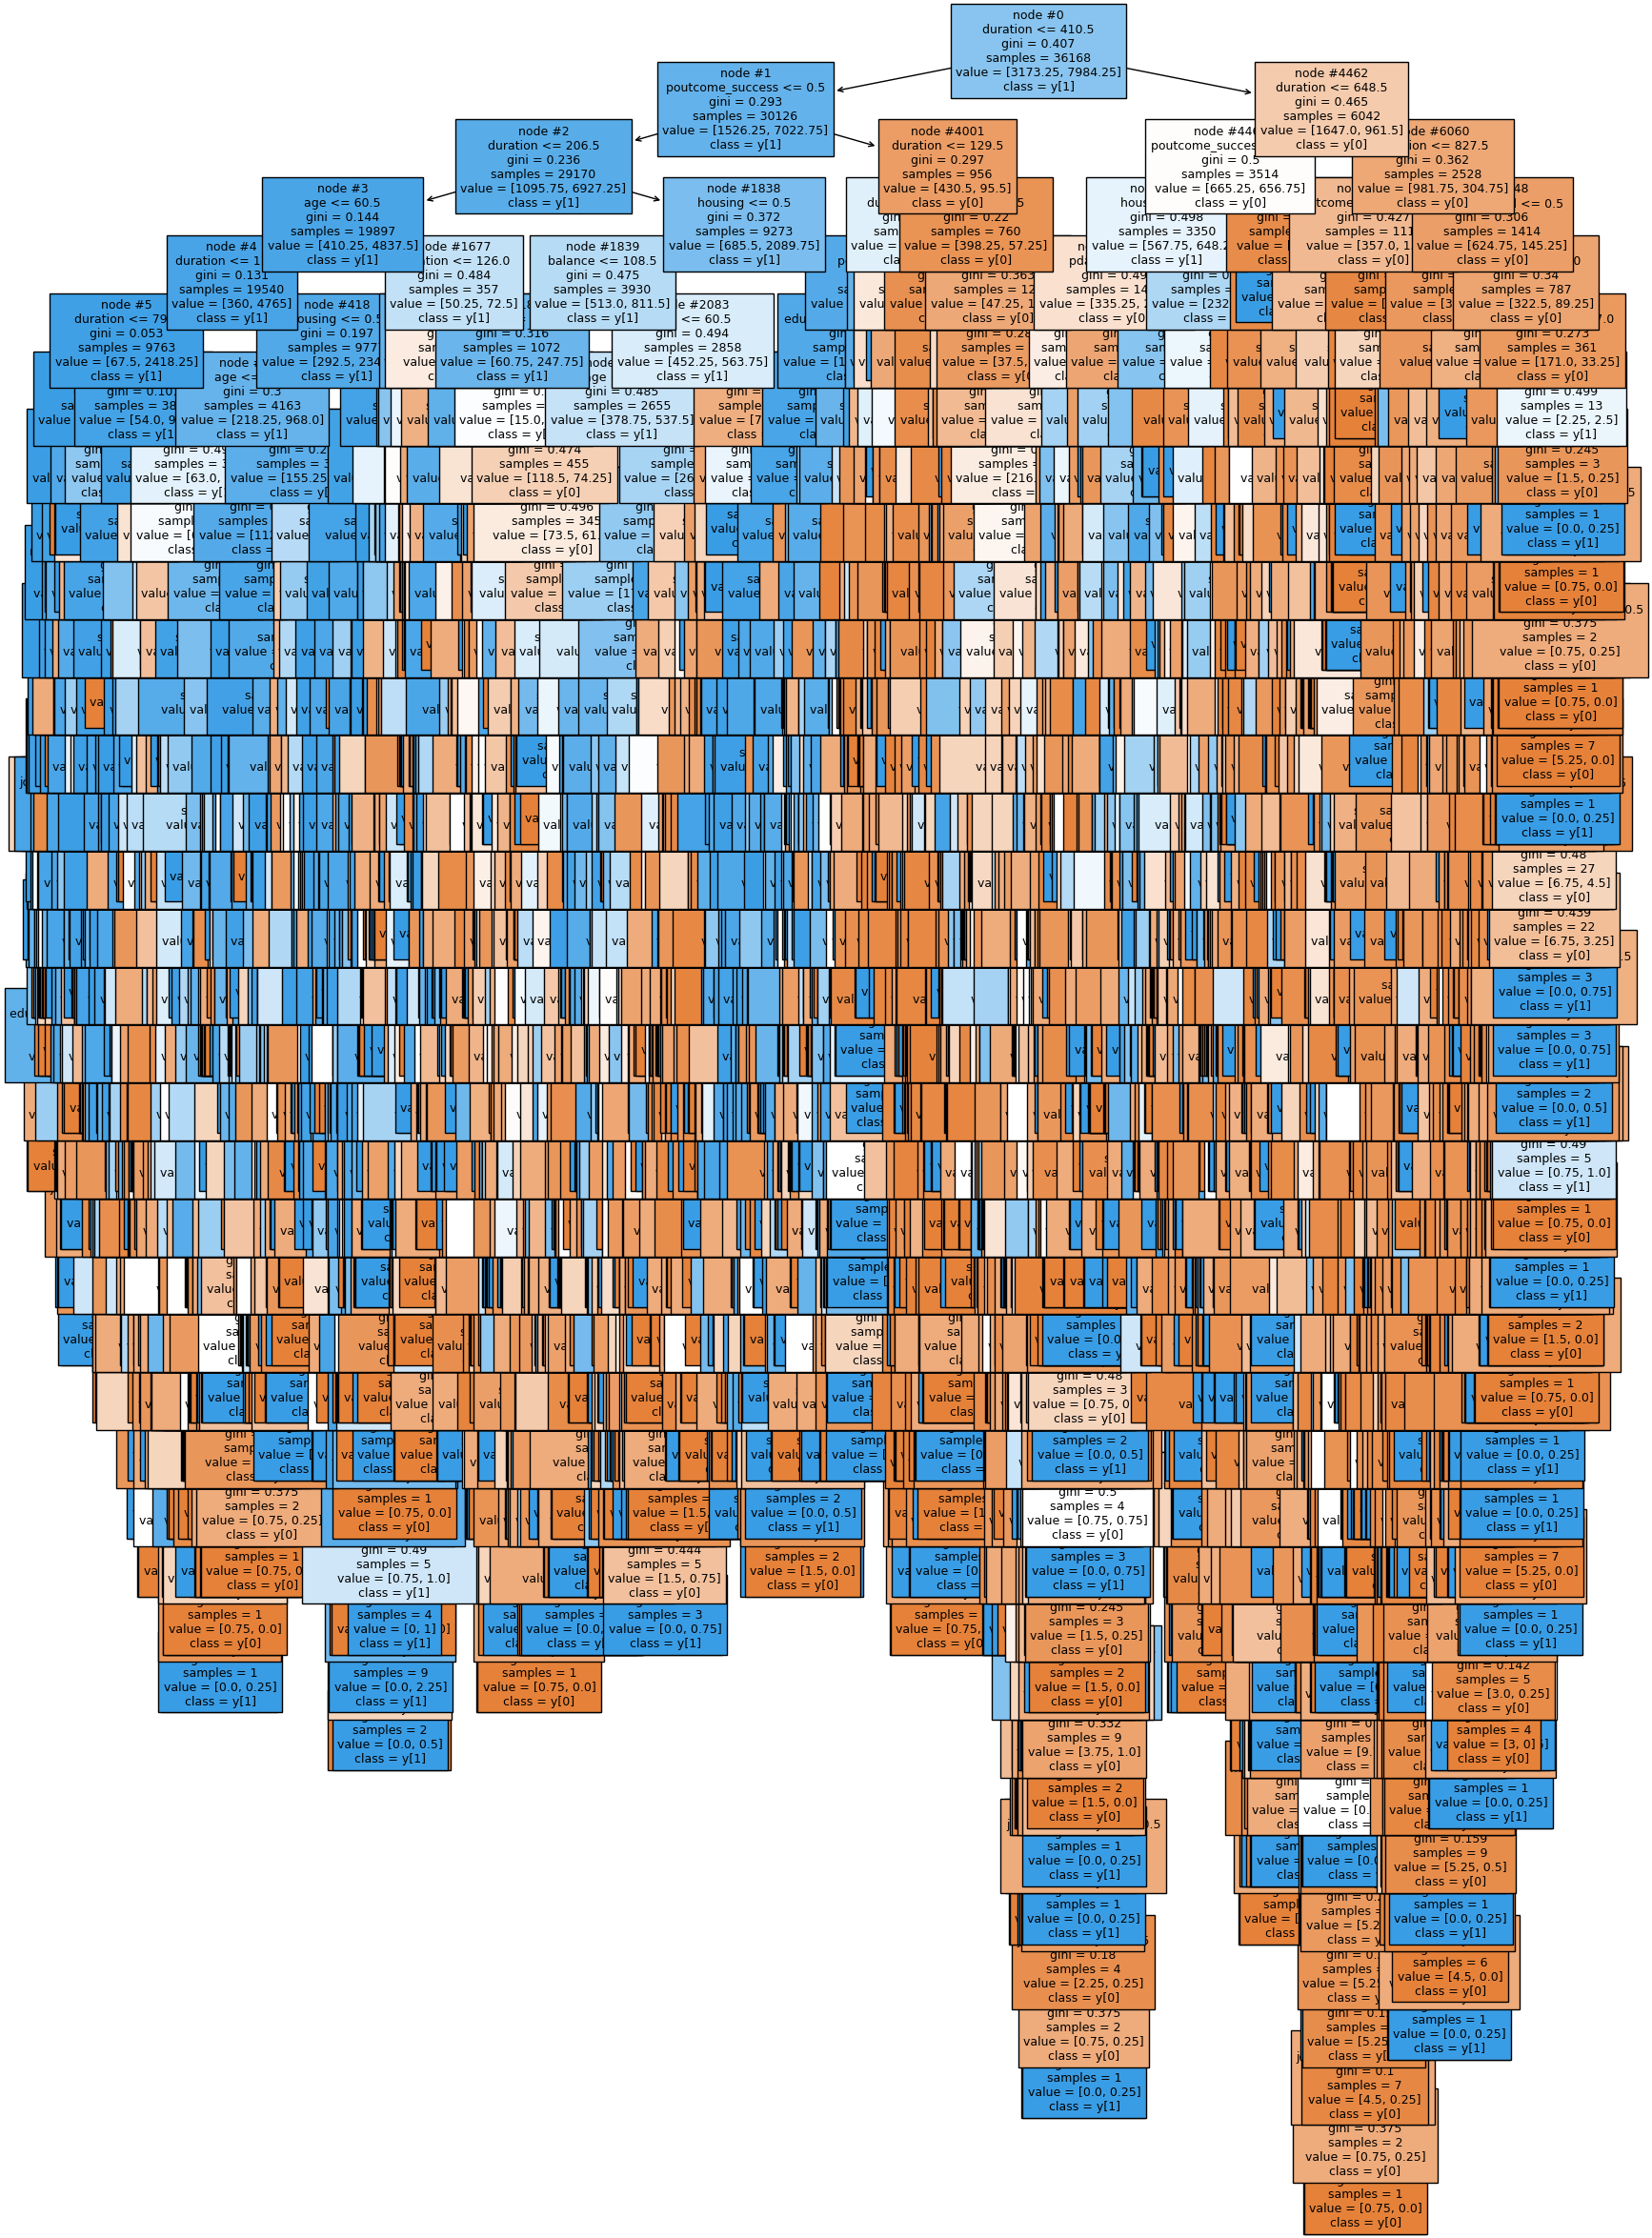

In [39]:
plottree(tree_model_random)

Function for plotting the features

In [40]:
def plot_features(model):
    feat_dict= {}
    for col, val in sorted(zip(features, model.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict[col]=val
    feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_df.Importance    
    idx = feat_df.Feature
    plt.figure(figsize=(10,8))
    clrs = ['navy']
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict client subscription')
    plt.show()

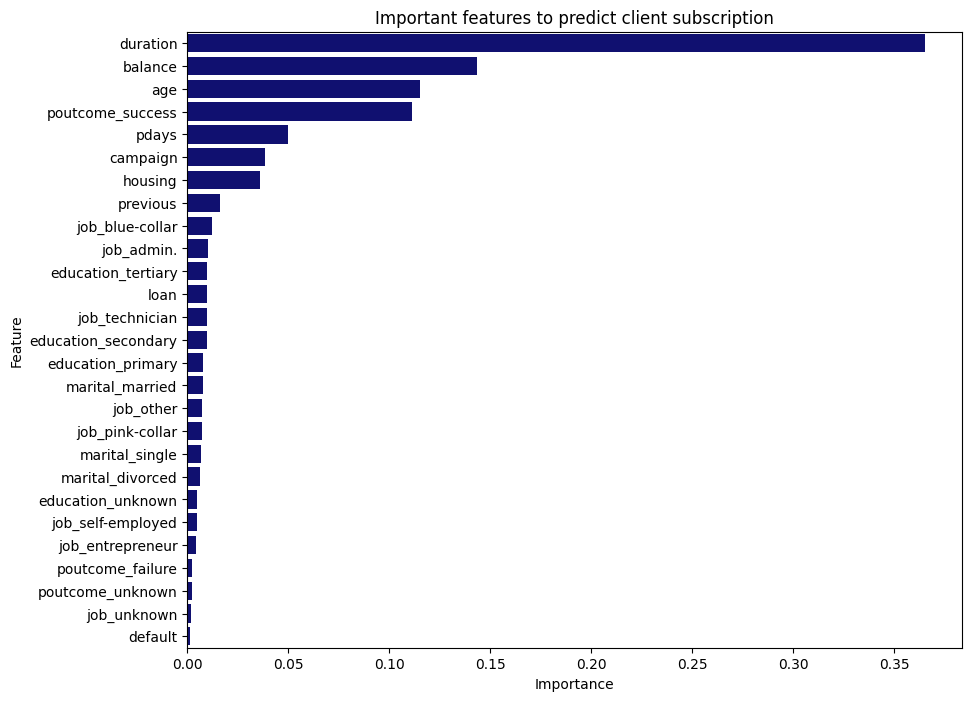

In [41]:
plot_features(tree_model_random)

Observations:
- As seen above the most important feature to predict a client subscription is the `Duration` of the term deposit.
- `Balance`, `Age`, `Poutcome_sucess`, `Pdays`are other important features that offer high contribution in the prediction.
-  The least important feature is `Duration`.

##### Grid Search for parameter tuning

In [73]:
estimator  = tree.DecisionTreeClassifier(random_state=1)

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'class_weight':[{1:0.25,0:0.75},{1:0.20,0:0.80}],
              'criterion': ['gini','entropy','log_loss']}
              
scorer = make_scorer(recall_score)

grid = GridSearchCV(estimator = estimator,param_grid = parameters,scoring = scorer, cv = 5)


In [74]:
grid = grid.fit(X_train,y_train)


In [76]:
#best combination
tree_model_best = grid.best_estimator_
tree_model_best

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, max_depth=3,
                       max_leaf_nodes=10, random_state=1)

Fitting the model with the best combination of paramters:

In [77]:
tree_model_best.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, max_depth=3,
                       max_leaf_nodes=10, random_state=1)

####################
Accuracy on train:  0.8965107277151073
Accuracy on test:  0.8929558774742895
####################
Recall on train:  0.9535961424053605
Recall on test:  0.9505322479649343
####################
Confusion Matrix on train:
Confusion Matrix on test:


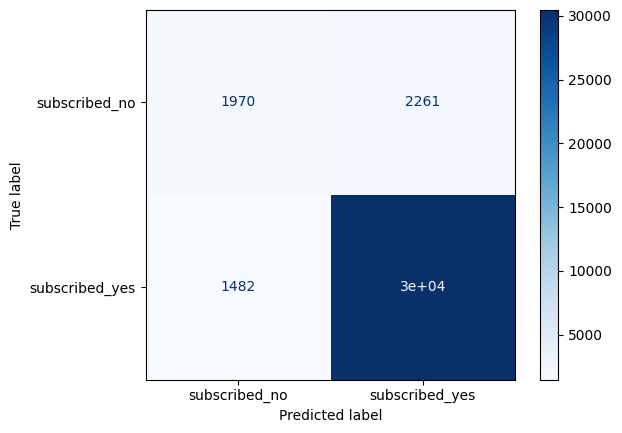

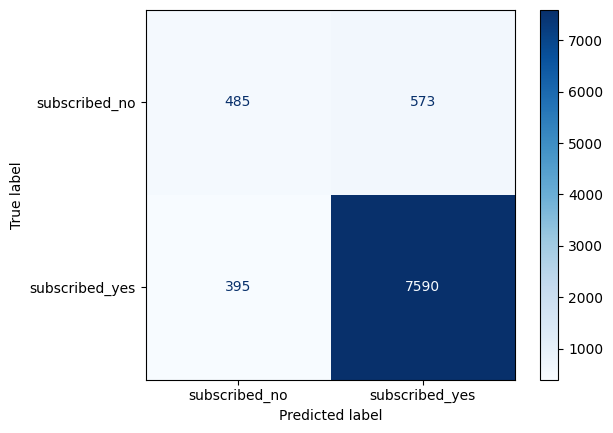

In [47]:
evaluate(tree_model_best)

Observations:

- Using the best model based on the CVGridSearch with parameters `class_weight={0: 0.75, 1: 0.25}, max_depth=3,
                       max_leaf_nodes=10, random_state=1 ` resulted in a decrease of the training overfit.
- Moreover, on test set the number of False Negatives decreased significantly from 688 to 395. The recall on test amounts now to 95%. 

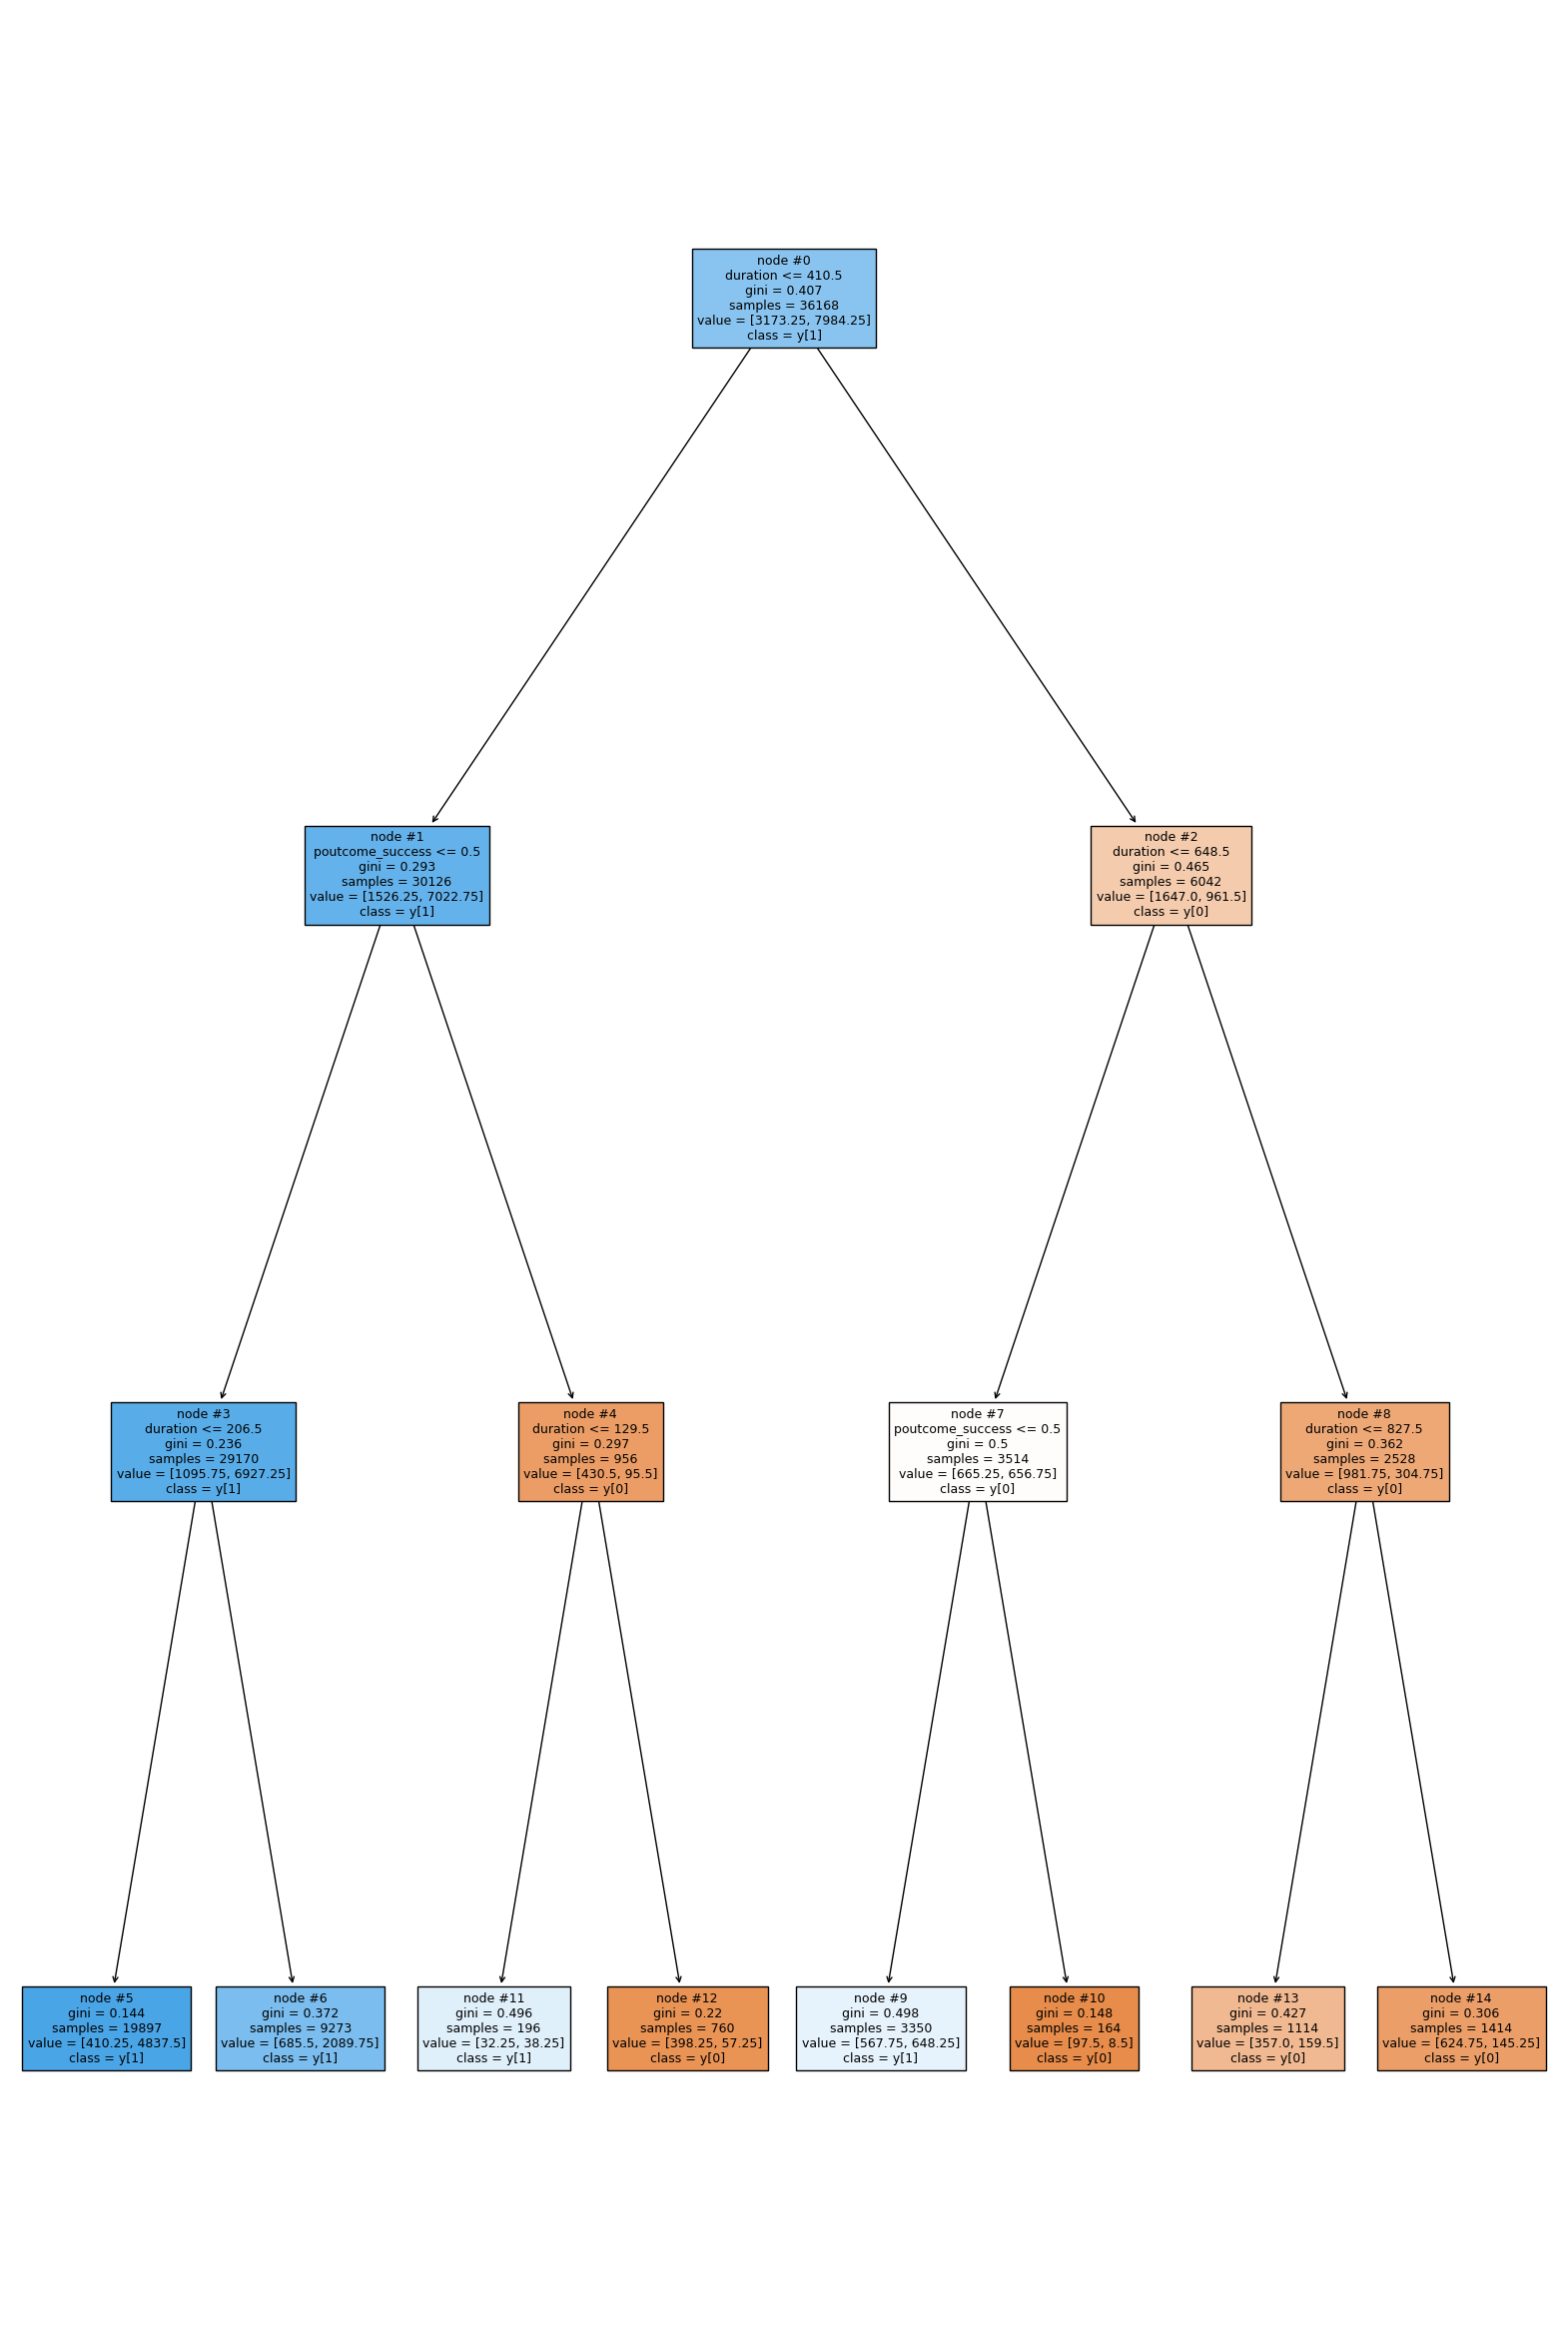

In [78]:
plottree(tree_model_best)

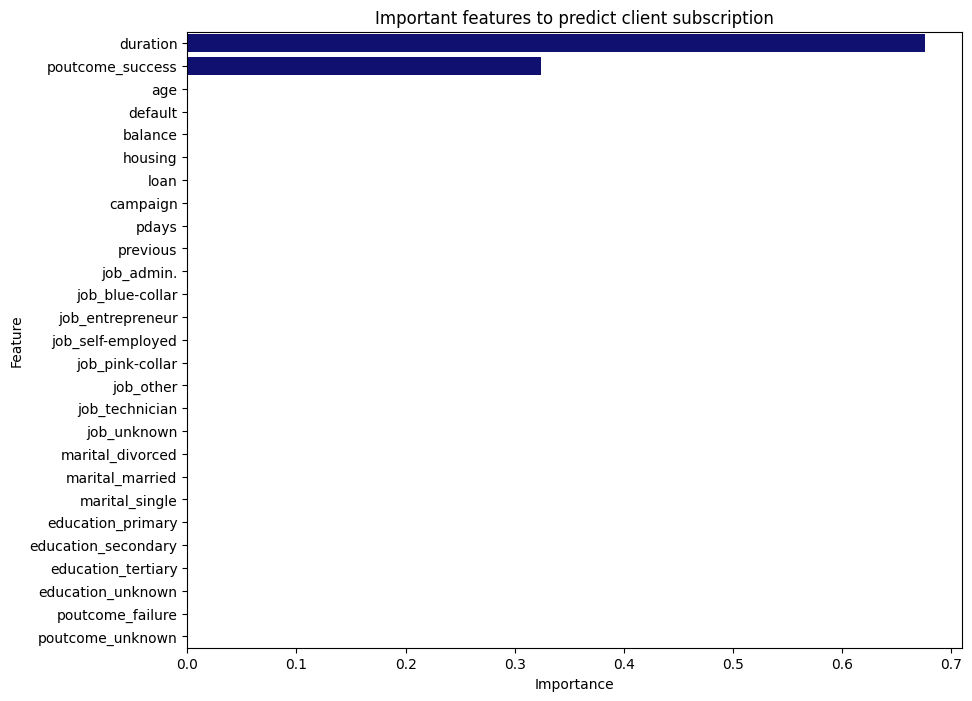

In [79]:
plot_features(tree_model_best)

Observations:

- According to the best model, the most important features for the prediction are `Duration` and `Poutcome_success`

##### Fitting another random model

In [81]:
tree_model_random2 = tree.DecisionTreeClassifier(criterion = 'entropy',class_weight={1:0.20,0:0.80},max_depth = 7,max_leaf_nodes =5,  random_state=1)
tree_model_random2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2}, criterion='entropy',
                       max_depth=7, max_leaf_nodes=5, random_state=1)

####################
Accuracy on train:  0.872898694978987
Accuracy on test:  0.873382726971138
####################
Recall on train:  0.9121395246892319
Recall on test:  0.9127113337507827
####################
Confusion Matrix on train:
Confusion Matrix on test:


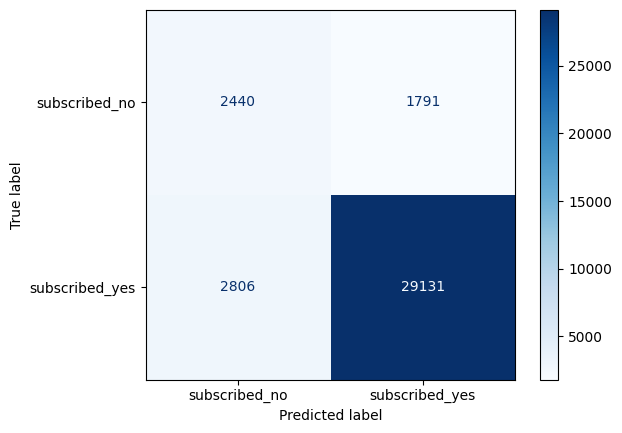

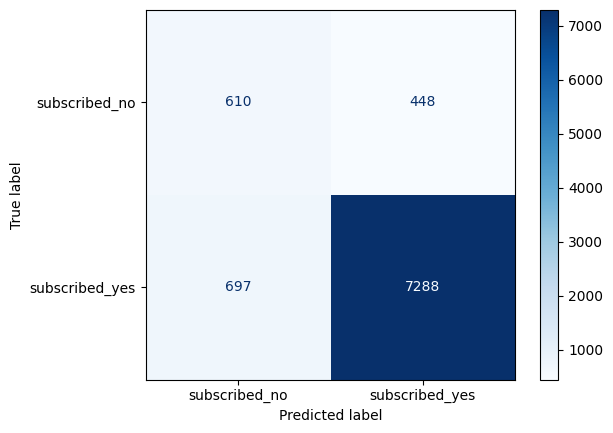

In [82]:
evaluate(tree_model_random2)

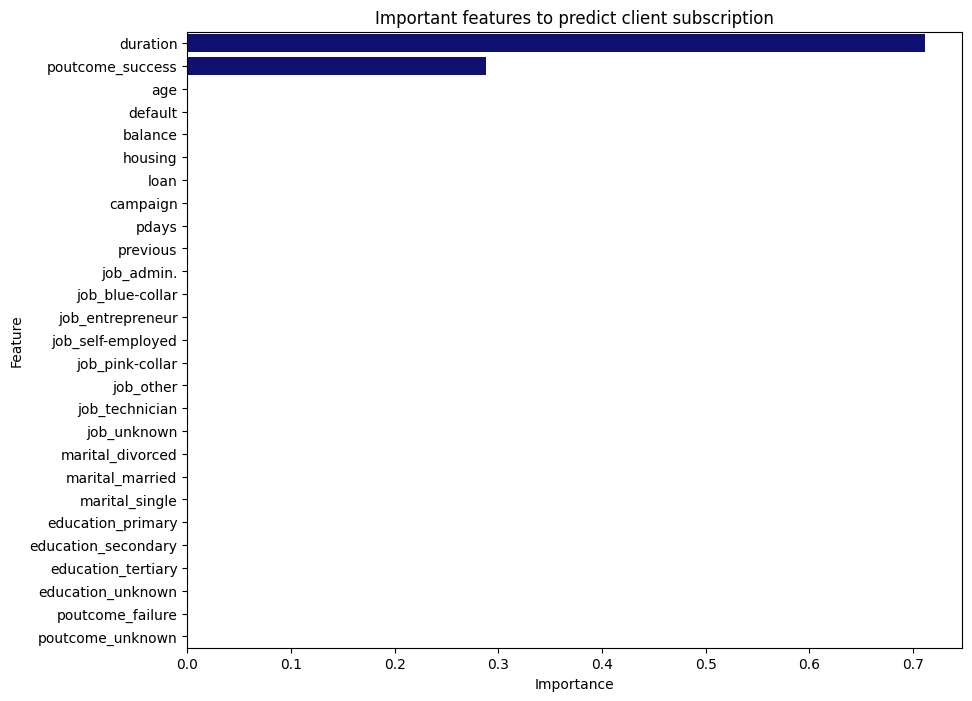

In [83]:
plot_features(tree_model_random2)

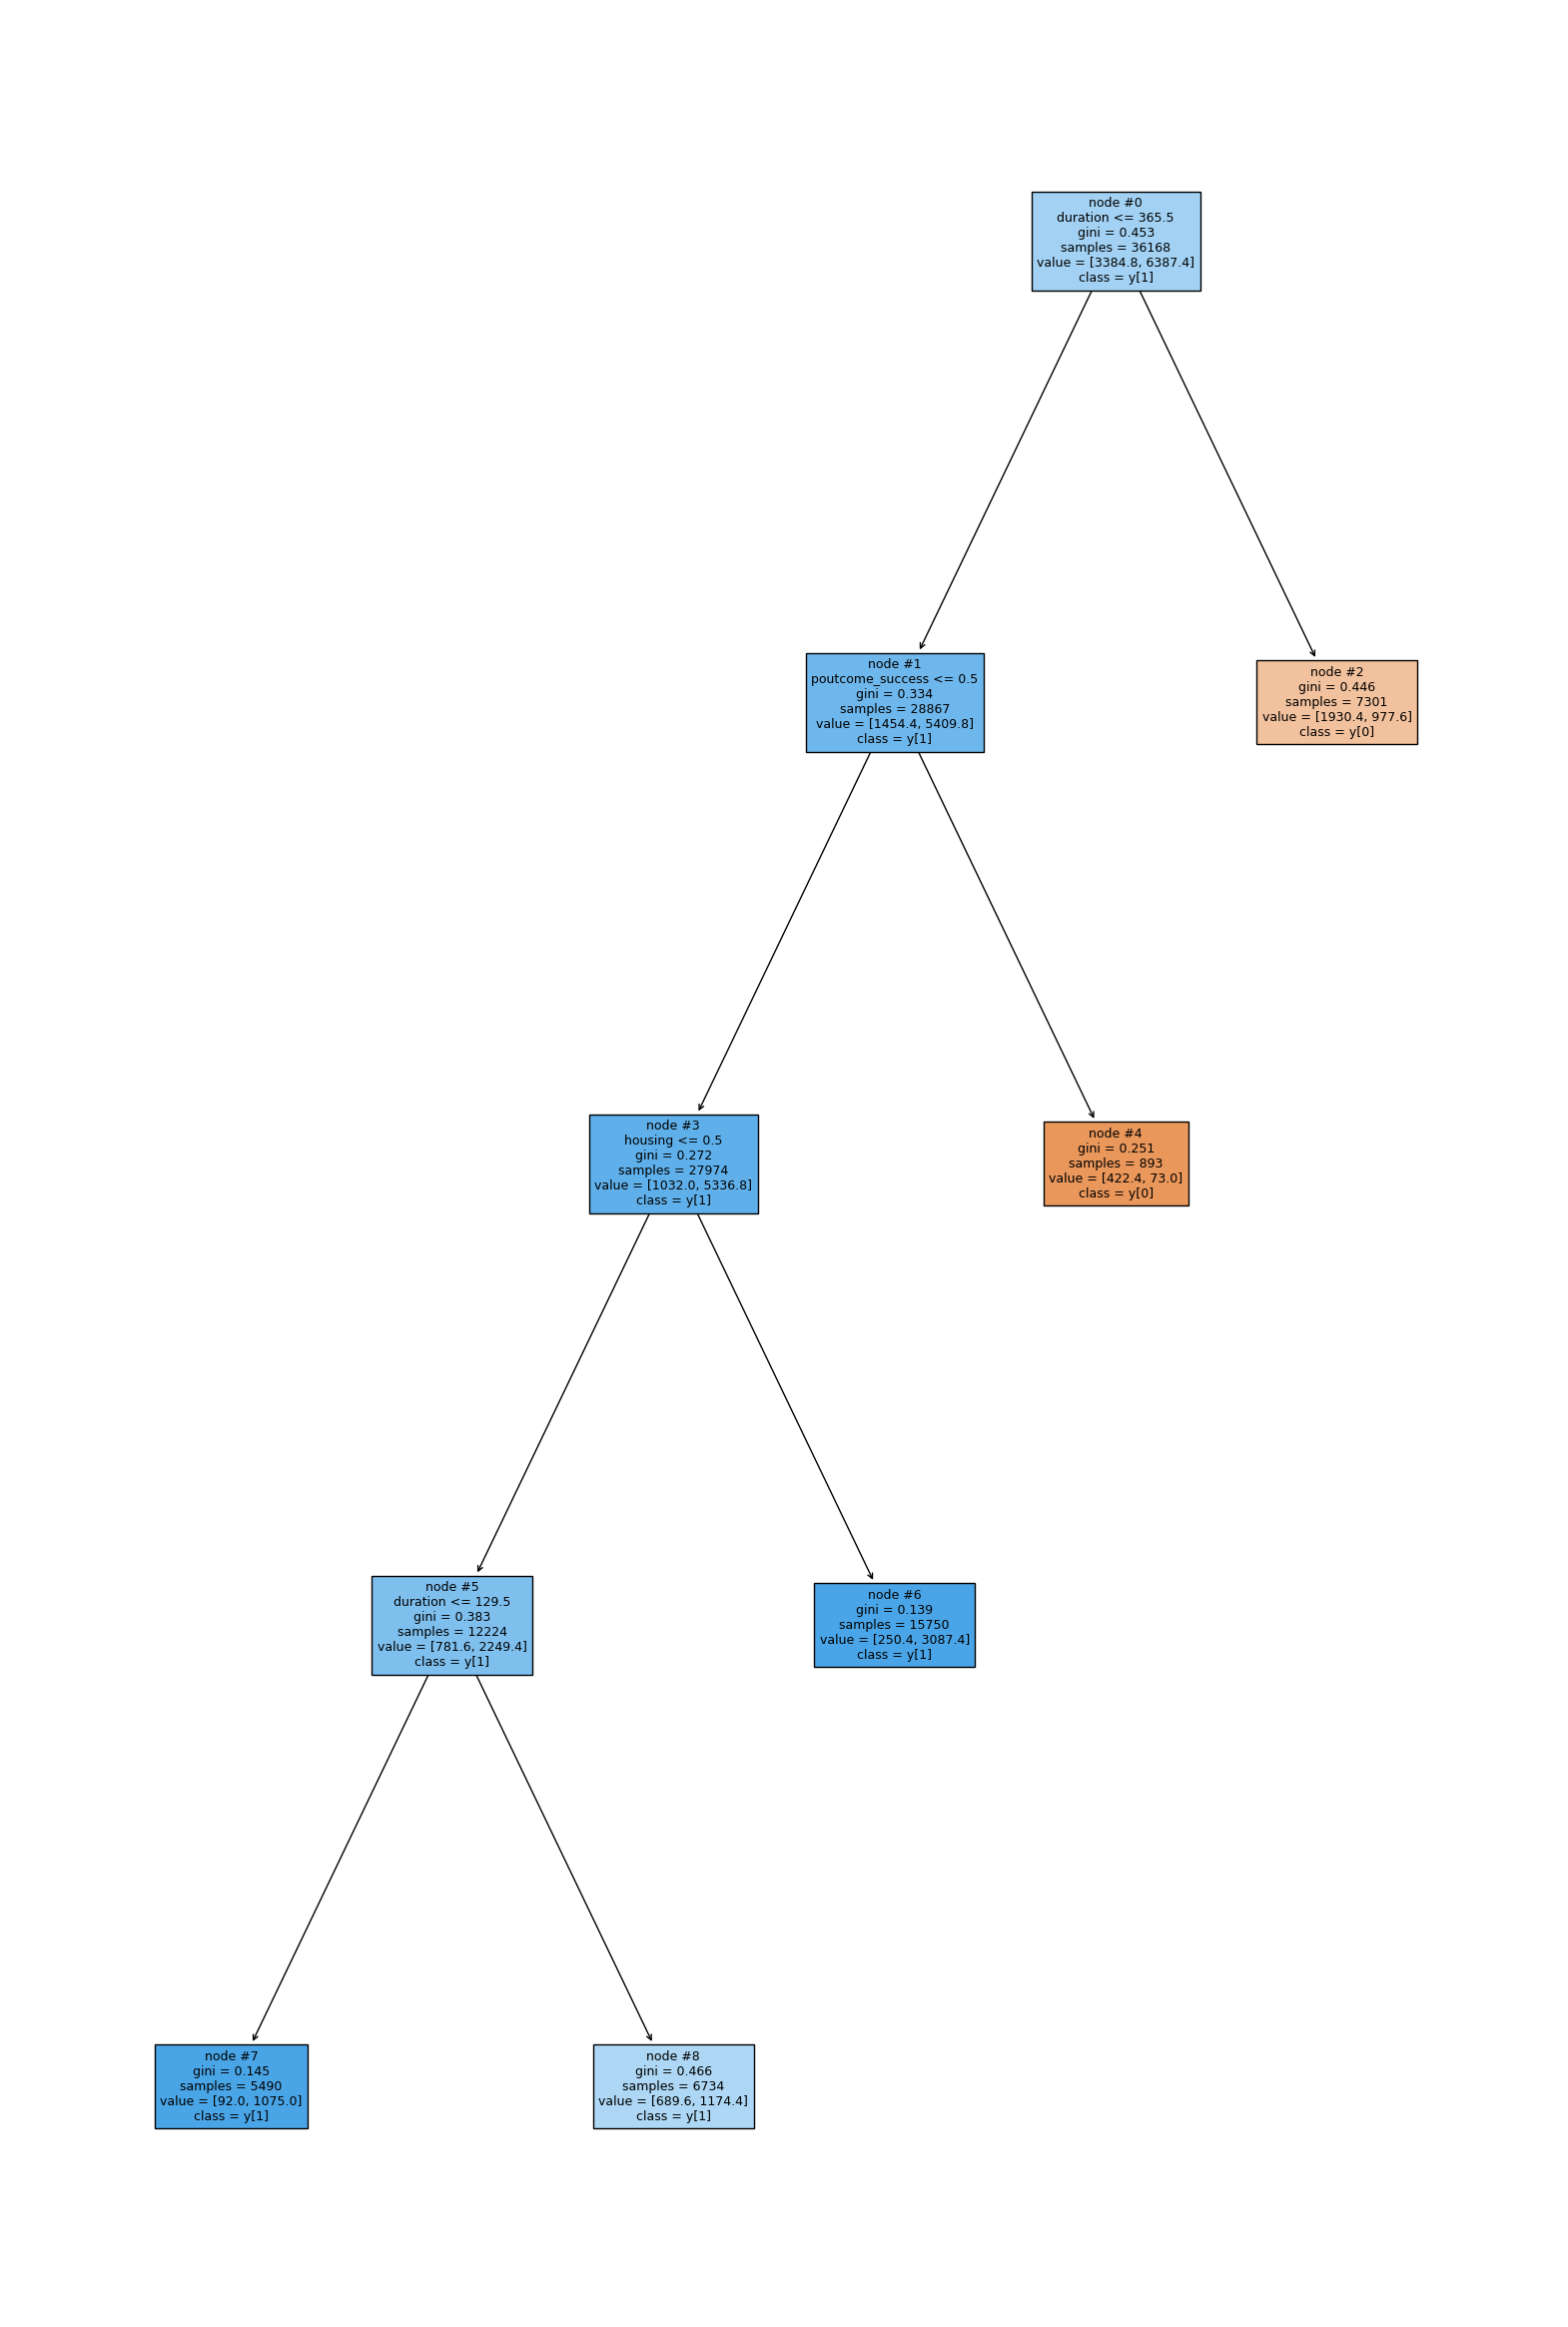

In [72]:
plottree(tree_model_random2)

Observations:
- This second random model performs the worst even on train set. 
- On test accuracy amounts to 87% while recall to 91%.
- Most important features include `Duration`, `Poutcome_sucess`. 

##### Cost Complexity Pruning of Tree
As last step of the Decision Tree model, we will perform post-pruning to try and improve the performance on the test set even more

In [90]:
ccp = tree_model_best.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = ccp.ccp_alphas, ccp.impurities

In [92]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, max_depth=3, max_leaf_nodes=10, random_state=1,ccp_alpha = ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)

In [93]:
def plot_ccp(clfs):
    train_acc = []
    test_acc = []

    for c in clfs:
        y_train_predict = c.predict(X_train)
        y_test_predict = c.predict(X_test)
        train_acc.append(accuracy_score(y_train,y_train_predict))
        test_acc.append(accuracy_score(y_test,y_test_predict))

    plt.scatter(ccp_alphas,train_acc)
    plt.scatter(ccp_alphas,test_acc)
    plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle = 'steps-post')
    plt.plot(ccp_alphas,test_acc,label = 'test_accuracy',drawstyle = 'steps-post')
    plt.legend()
    plt.title('Accuracy vs Alpha')
    plt.show()

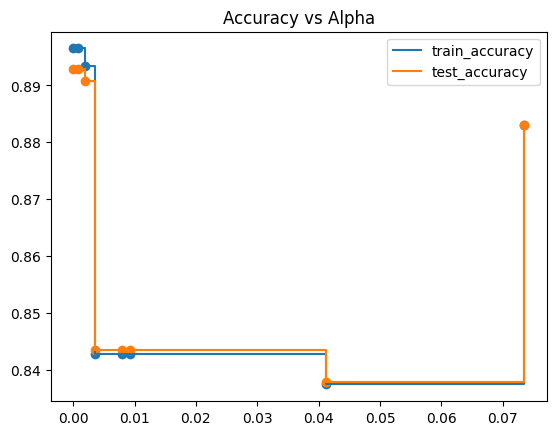

In [94]:
plot_ccp(clfs)

Observations:
- According to the plot above, changing the cost complexity pruning parameter would not result in better results. It looks like having a `ccp_alpha` of 0 leads to the best performance in train and test.